In [1]:
import os
import pickle
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, pyplot as plt

In [2]:
CAF_DOSE = 200

SIGNIFICANT_P = 0.05
SIGNIFICANT_P_STRONG = 0.01
STRONG_SIGNIFICANCE_COLOR = 'w'

PROJECT_PATH = '../data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '../results'
FIGURE_PATH = '../figures'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3 ', 'P4',
            'O1', 'O2 ', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
with open(os.path.join(RESULTS_PATH, 'difference', f'total{CAF_DOSE}.pickle'), 'rb') as file:
    diff = pickle.load(file)

'''    
delete_features = ['PSD_alpha', 'PSD_low gamma', 'PermEn', 'SpecPermEn']
for stage in STAGES:
    for delete in delete_features:
        del diff[stage][delete]
'''

"    \ndelete_features = ['PSD_alpha', 'PSD_low gamma', 'PermEn', 'SpecPermEn']\nfor stage in STAGES:\n    for delete in delete_features:\n        del diff[stage][delete]\n"

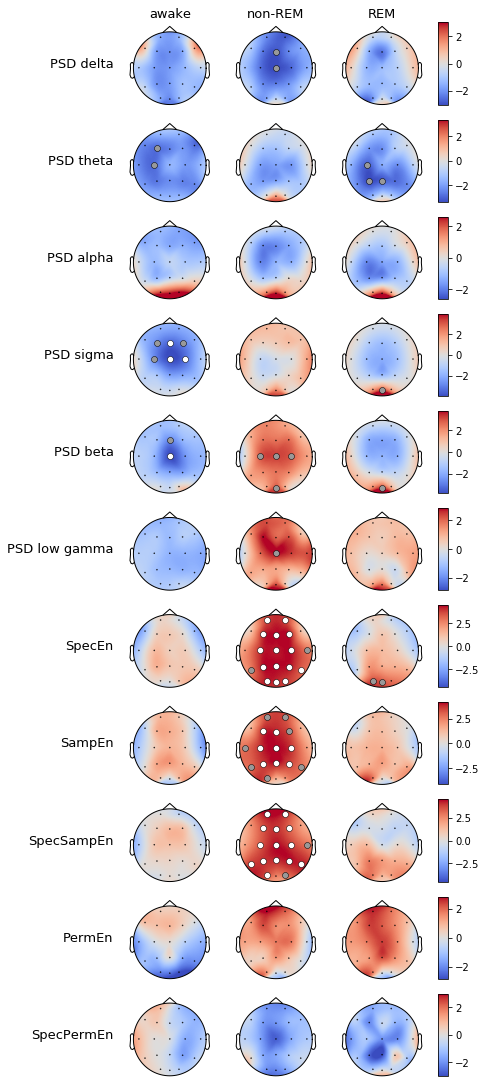

In [5]:
fontsize_small = 13
fontsize_big = 20
colormap = 'coolwarm'

width = len(STAGES)
height = len(diff[STAGES[0]])

# create gridspec
gs = gridspec.GridSpec(height + 1,
                       width + 2,
                       width_ratios=[0.001] + [1] * width + [0.1],
                       height_ratios=[0.01] + [1] * height,
                       wspace=0.1)
subplot_counter = 1
#plt.figure(figsize=(6, 12)) # poster version
plt.figure(figsize=(6, 18)) # full version
feature_labels = []

# add stage annotations
for stage in STAGES:
    plt.subplot(gs[subplot_counter])
    subplot_counter += 1
    feature_labels.append(plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                                       xy=(0.5, 0),
                                       ha='center',
                                       va='top',
                                       fontsize=fontsize_small))
    plt.axis('off')
subplot_counter += 1

for feature in diff[STAGES[0]].keys():
    # add feature annotations
    plt.subplot(gs[subplot_counter])
    subplot_counter += 1
    
    name = feature.replace('_', ' ').replace('SpecShanEn', 'SpecEn')
    feature_labels.append(plt.annotate(name, xy=(1, 0.5), ha='right', va='center', fontsize=fontsize_small))
    plt.axis('off')
    
    # get min and max values for plots and colorbars
    vmin = np.min([np.min(diff[stage][feature]['t_statistic']) for stage in STAGES])
    vmax = np.max([np.max(diff[stage][feature]['t_statistic']) for stage in STAGES])
    absolute = max(abs(vmin), abs(vmax))
    vmin = -absolute
    vmax = absolute

    axes = []
    for stage in STAGES:
        axes.append(plt.subplot(gs[subplot_counter]))
        subplot_counter += 1
        
        # get significance marker params
        mask = diff[stage][feature]['p_value'] < SIGNIFICANT_P
        marker_colors = [[0.6, 0.6, 0.6]] * len(mask)
        for i in np.where(diff[stage][feature]['p_value'] < SIGNIFICANT_P_STRONG)[0]:
            marker_colors[i] = STRONG_SIGNIFICANCE_COLOR
        marker_colors = np.array(marker_colors)[mask]
        
        # plot topomaps
        viz.plot_topomap(diff[stage][feature]['t_statistic'],
                         sensor_pos,
                         mask=mask,
                         vmin=vmin,
                         vmax=vmax,
                         mask_params={'markersize': 6, 'markeredgewidth': 0.5, 'markerfacecolor': marker_colors},
                         cmap=colormap,
                         contours=False,
                         show=False)
    
    # add colorbar
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=plt.subplot(gs[subplot_counter]))
    subplot_counter += 1
    
plt.savefig(os.path.join(FIGURE_PATH, 'fig_1-diff-topo'),
            bbox_inches='tight',
            bbox_extra_artists=feature_labels,
            transparent=True,
            dpi=300)
plt.show()